# RLLBC Bonus Point Assignment II Part C
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2022-06-24</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym
import optparse
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

### Render Environment

In [2]:
import time
import flappy_bird_gym
env = flappy_bird_gym.make("FlappyBird-v0")
for i in range(3):
    obs = env.reset()
    while True:
        # Next action:
        # (feed the observation to your agent here)
        action = ...  # env.action_space.sample() for a random action

        # Processing:
        obs, reward, done, info = env.step(action)
    
        # Rendering the game:
        # (remove this two lines during training)
        env.render()
        time.sleep(1 / 30)  # FPS
    
        # Checking if the player is still alive
        if done:
            break

env.close()

### Replay Memory

In [3]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

### Actor and Critic Networks

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
            nn.Linear(state_dim, n_latent_var),
            nn.Tanh(),
            nn.Linear(n_latent_var, n_latent_var),
            nn.Tanh(),
            nn.Linear(n_latent_var, action_dim),
            nn.Softmax(dim=-1)
        )

        # critic
        self.value_layer = nn.Sequential(
            nn.Linear(state_dim, n_latent_var),
            nn.Tanh(),
            nn.Linear(n_latent_var, n_latent_var),
            nn.Tanh(),
            nn.Linear(n_latent_var, 1)
        )

    def forward(self, state):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        return action.item()

    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

## Proximal Policy Optimization

### a) compute MC estimates
### b) compute surrogate loss funcitons

In [6]:
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def update(self, memory):
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            #--------------------
            # TODO compute every-visit MC estimate of state values (variable name: discounted_reward)
            #--------------------
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + discounted_reward * self.gamma
            rewards.insert(0, discounted_reward)
            

                
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            #--------------------
            # TODO implement the two surrogate loss functions of formula (7) in the PPO paper
            #--------------------
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

### e) Hyperparameter Tuning

In [7]:
env_name = "FlappyBird-v0"
# creating environment
env = flappy_bird_gym.make("FlappyBird-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
render = False
solved_reward = 230  # stop training if avg_reward > solved_reward
log_interval = 20  # print avg reward in the interval
max_episodes = 2000  # max training episodes
max_timesteps = 300  # max timesteps in one episode
n_latent_var = 64  # number of variables in hidden layer
update_timestep = 200  # update policy every n timesteps
lr = 0.002 
gamma = 0.99  # discount factor
K_epochs = 4  # update policy for K epochs
eps_clip = 0.5  # clip parameter for PPO
random_seed = 42

## Training Loop
### c) Data collection
### d) Policy update

FlappyBird-v0 Clipping: 0.5


  0%|          | 0/2000 [00:00<?, ?it/s]

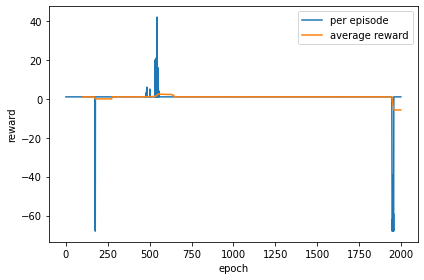

In [8]:
torch.manual_seed(random_seed)
env.seed(random_seed)

memory = Memory()
ppo = PPO(state_dim, action_dim, n_latent_var, lr, gamma, K_epochs, eps_clip)
print(env_name, "Clipping:", eps_clip)

# logging variables
rewards = []
lengths = []
timestep = 0
def save_statistics():
    with open(f"./solution/PPO_{env_name}-eps{eps_clip}-k{K_epochs}-s{random_seed}-stat.pkl", 'wb') as f:
        pickle.dump({"rewards": rewards, "lengths": lengths, "eps": eps_clip, "epochs": K_epochs}, f)
# training loop
with tqdm(range(1, max_episodes + 1)) as pbar:
    for i_episode in pbar:
        state = env.reset()
        running_reward = 0
        t=0
        while True:
            timestep += 1
            t+=1

            # Running policy_old:
            #--------------------
            #TODO interact with the environment using policy_old and store the transitions and whether the rollout
            # terminated as well as the log probabilities in the memory.
            #--------------------
            action = ppo.policy_old.act(state,memory)
            state, reward, done, _ = env.step(action)
            memory.is_terminals.append(done)
            memory.rewards.append(reward)
            # update if its time
            if timestep % update_timestep == 0:
                #--------------------
                #TODO update PPO policy, clear memory afterwards
                #--------------------
                ppo.update(memory)
                memory.clear_memory()
            running_reward += reward
            if render:
                env.render()
                time.sleep(1 / 100)  # FPS
            if done:
                running_reward -= 100
                break

        rewards.append(running_reward)
        lengths.append(t)
        pbar.set_description(f"Mean training reward {np.mean(rewards[-log_interval:]):.02f}")
        if np.mean(rewards[-log_interval:]) >= solved_reward:
            break  # Stop training
                
save_statistics()
torch.save(ppo.policy.state_dict(), f'./solution/PPO_{env_name}-eps{eps_clip}.pth')

# Plot training
plt.plot(rewards, label="per episode")
plt.plot(pd.DataFrame(rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/ppo.png")

In [9]:

# creating environment
env = flappy_bird_gym.make("FlappyBird-v0")
ppo.policy.eval()#switch to evaluation mode
def _rollout(seed):
    running_reward = 0.0
    env.seed=seed
    state, done = env.reset(), False
    while not done:
        action = ppo.policy.forward(state)
        state, reward, done, _ = env.step(action)
        running_reward += reward
    return running_reward


_avg_return = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_return >=200 , f"Average reward below 50, got {_avg_return}"
f"ok (Average reward {_avg_return:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: Average reward below 50, got 101.0

In [ ]:
# Take a look at the learned policy (this will not run on the JupyterHub)
env_name = "FlappyBird-v0"
# creating environment
env= flappy_bird_gym.make("FlappyBird-v0")
for i in range(10):
    env.seed(i)
    state, done = env.reset(), False
    while not done:
        action = ppo.policy.forward(state)
        state, _, done, _ = env.step(action)
        env.render()
        time.sleep(1 / 30)  # FPS

env.close()